In [33]:
import importlib
import json
import requests
import os
import pandas as pd
import numpy as np

from sammo.runners import OpenAIChat
from sammo.base import Template, EvaluationScore
from sammo.components import Output
from sammo.data import DataTable
from sammo.instructions import MetaPrompt, Section, Paragraph, InputData, FewshotExamples
from sammo.dataformatters import JSONDataFormatter
import sammo.search_op
import sammo.search

# Stop wasting LLM tokens

If you use LLMs to annotate or process larger datasets, chances are that you're not even realizing that you are wasting a lot of input tokens. As you repeatedly call an LLM to process text snippets or entire documents, your task instructions and static fewshot examples are repeated for every input example. Batching examples to be annotated together is an often-underused technique and can result in substantial savings.

## How much minibatching can save
Here is a quick back-of-the-envelope analysis of how much minibatching can save. If we assume that our average document length is $D$ tokens and our instructions and few-shot examples have $r \cdot D$ tokens, and we have minibatch size of $B$, then we have amortized costs of $D + \frac{rD}{B}$. With a tiny bit of work, we get $$\mathrm{relative\;\;savings} = \frac{r(1-\frac1B)}{1+r}.$$

Below I have plotted the relative savings with increasing minibatch sizes for three different lengths of shared instructions. The main takeaways are:

* As expected, the longer the shared instructions, the higher our savings
* Savings quickly drop off with minibatch size, with most benefits seen with a batch size of 10

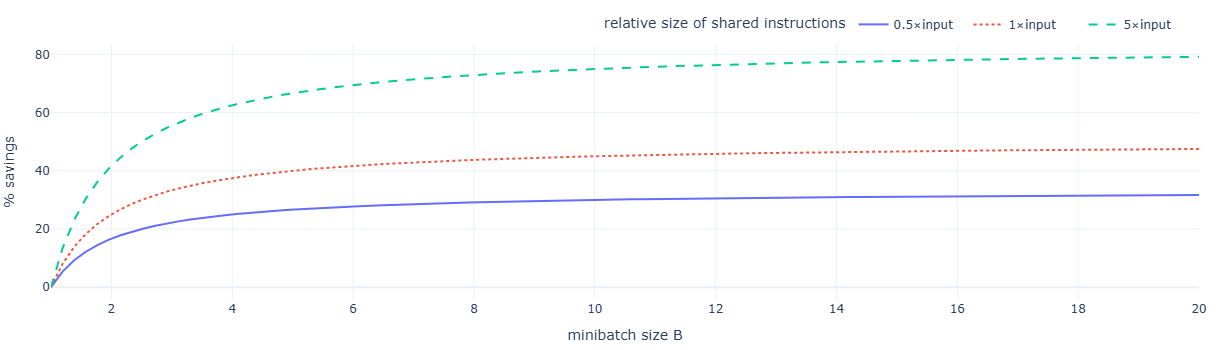

In [34]:
def plot_savings():
    B_values = np.linspace(1, 20, 100)
    dfs = list()
    for r in [0.5, 1, 5]:
        df_r = pd.DataFrame(
            {"B": B_values, "Function": 100 * r * (1 - 1 / B_values) / (1 + r), "r": f"{r}⨯input"}
        )
        dfs.append(df_r)
    dfs = pd.concat(dfs, ignore_index=True)

    fig = px.line(
        dfs,
        x="B",
        y="Function",
        color="r",
        template="plotly_white",
        labels={
            "Function": "% savings",
            "B": "minibatch size B",
            "r": "relative size of shared instructions",
        },
        line_dash='r',
    )
    fig.update_layout(
        legend=dict(orientation="h", entrywidth=70, yanchor="bottom", y=1.02, xanchor="right", x=1)
    )
    fig.update_layout(margin=dict(l=10, r=10, t=10, b=10), width=600, height=350)
    fig.write_image("relative_savings.png", scale=2)

    fig.show()

if importlib.util.find_spec("plotly"):
    import plotly.express as px
    plot_savings()
else:
    print("Please install plotly to plot!")

## Minibatching in practice
Let's turn practical with a task where we want to categorize pieces of text for further analysis. We'll use a fun task from the Natural-Instructions benchmark where we need to annotate sentences in debates with one of four categories (value, fact, testimony or policy).

In [35]:
URL = "https://github.com/allenai/natural-instructions/raw/master/tasks/task375_classify_type_of_sentence_in_debate.json"
task = json.loads(requests.get(URL).content)

for x in task["Instances"]:
    topic, sentence = x["input"][7:].split("\nsentence: ")
    x["input"] = {"topic": topic, "sentence": sentence}
    x["output"] = x["output"][0]

df = pd.DataFrame(task["Instances"]).drop(columns="id")

d_train, d_fewshot = DataTable.from_pandas(df).random_split(100, 20)

Looking at an example, we see that it contains the current topic for context as well as the sentence in question.

In [36]:
print(df.sample(1, random_state=1).to_json(orient="records", indent=2))

[
  {
    "input":{
      "topic":"the fight for justice,equality,peaceand love is futile",
      "sentence":"What matters is what I am personally doing to ensure that I am filling the cup!"
    },
    "output":"Value"
  }
]


### Automatic minibatching with the SAMMO

To run our experiments, we'll use SAMMO, a framework for LLM calling and prompt optimization. 

Prompts are coded up in SAMMO as prompt programs (which are simply nested Python classes that'll be called with input data). We'll structure our task into three sections and format our minibatches in  JSON format.

In [37]:
runner = OpenAIChat(
    model_id="gpt-4o",
    api_config={"api_key": os.getenv("OPENAI_API_KEY", ValueError("Please set OPENAI_API_KEY"))},
    cache=os.getenv("CACHE_FILE", "cache.tsv"),
    rate_limit=5,
)


def accuracy(y_true: DataTable, y_pred: DataTable) -> EvaluationScore:
    y_true = y_true.outputs.values
    y_pred = y_pred.outputs.normalized_values()
    n_correct = sum([str(y_p).lower() == y_t.lower() for y_p, y_t in zip(y_pred, y_true)])

    return EvaluationScore(n_correct / len(y_true))


def prompt_program(fewshot_data, n_fewshot_examples=5, minibatch_size=1):
    return Output(
        MetaPrompt(
            [
                Section("Instructions", task["Definition"]),
                Section("Examples", FewshotExamples(fewshot_data, n_examples=n_fewshot_examples)),
                Section("Output in same format as above", InputData()),
            ],
            data_formatter=JSONDataFormatter(),
            render_as="markdown",
        ).with_extractor(on_error="empty_result"),
        minibatch_size=minibatch_size,
        on_error="empty_result",
    )

In [38]:
pred_batchsize_1 = prompt_program(d_fewshot).run(runner, d_train)
print(pred_batchsize_1.outputs.costs)
print(f"Accuracy: {accuracy(d_train, pred_batchsize_1).score}")

minibatches[###############################################################################]100/100[00:00<00:00, 9.17it/s]
Costs(input=58255, output=5817)
Accuracy: 0.76


### Exploring different minibatch sizes
Let's now explore how minibatching affects costs and performance. Since minibatching reduces the total input costs, we can now use some of those savings to add more fewshot examples! We can study those trade-offs by setting up a search space in SAMMO:

In [26]:
def search_space(fewshot_data):
    minibatch_size = sammo.search_op.one_of([1, 5, 10], name="minibatch_size")
    n_fewshot_examples = sammo.search_op.one_of([5, 20], name="n_fewshot_examples")

    return prompt_program(fewshot_data, n_fewshot_examples, minibatch_size)

Running this shows us the full gamut of trade-offs:

In [27]:
sammo_model = sammo.search.EnumerativeSearch(
    runner, lambda: search_space(d_fewshot), accuracy, maximize=True
)
sammo_model.fit(d_train)
sammo_model.show_report()

candidate[###################################]6/6[00:00<00:00] >> minibatches (total)[#####################]260/260[00:00<00:00]

Fitting log (6 entries):
iteration    action                                            objective    costs                              parse_errors
-----------  ------------------------------------------------  -----------  ---------------------------------  --------------
0            {'minibatch_size': 1, 'n_fewshot_examples': 5}    0.76         {'input': 58255, 'output': 5817}   0.0
1            {'minibatch_size': 1, 'n_fewshot_examples': 20}   0.76         {'input': 133355, 'output': 6234}  0.0
2            {'minibatch_size': 5, 'n_fewshot_examples': 5}    0.75         {'input': 15297, 'output': 5695}   0.0
3            {'minibatch_size': 5, 'n_fewshot_examples': 20}   0.77         {'input': 30317, 'output': 5524}   0.0
4            {'minibatch_size': 10, 'n_fewshot_examples': 5}   0.73         {'input': 9928, 'output': 5633}    0.0
5            {'minib

So, even with 20 fewshot examples, we save nearly 70 % input costs ([58255–17538]/58255) all while maintaining overall accuracy!